In [1]:
%matplotlib notebook
from pyluos import Robot
from IPython.display import clear_output
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

# 1. Connect your Luos network (here using an USB module for example)
r = Robot('/dev/cu.usbserial-DN05NM15')
print(r.modules)

# 2. Select the module of your network you need to configure
module = r.disk_middle

# 3. Setup module basic settings
module.encoder_res = 5
module.reduction = 77.35

SAMPLERATE = 1.0/module.sampling_freq

def run_speed_test(velocity_target):
    module.rot_position = False
    module.rot_speed = True
    module.current = True
    module.rot_position_mode = False
    module.rot_speed_mode = True
    module.target_rot_speed = 0.0
    module.compliant = False
    target = []
    real = []
    current = []
    test_time_vector = []
    test_start_time = time.time()
    target.append(module.target_rot_speed)
    real.append(module.rot_speed)
    current.append(module.current)
    test_time = time.time()
    test_time_vector.append(0.0)
    while (test_time < test_start_time + 0.5):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_speed)
        real.append(module.rot_speed)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.target_rot_speed = velocity_target
    while (test_time < test_start_time + 2.5):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_speed)
        real.append(module.rot_speed)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.compliant = True
    plot_test(test_time_vector, target, real, current)

def run_pos_test(pos_target):
    module.rot_speed = False
    module.rot_position = True
    module.current = True
    module.rot_speed_mode = False
    module.rot_position_mode = True
    module.target_rot_position = 0.0
    module.compliant = False
    target = []
    real = []
    current = []
    test_time_vector = []
    test_start_time = time.time()
    target.append(module.target_rot_position)
    real.append(module.rot_position)
    current.append(module.current)
    test_time = time.time()
    test_time_vector.append(0.0)
    while (test_time < test_start_time + 1):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_position)
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.target_rot_position = pos_target
    while (test_time < test_start_time + 2.5):
        time.sleep(SAMPLERATE)
        target.append(module.target_rot_position)
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
        
    # create a smooth trajectory
    moveduration = 2
    keypoints = np.array([40, 4, -10, -33, -17, -27, 10, -40, 0])
    x = np.linspace(0, 1, keypoints.shape[-1], endpoint=True)
    traj = interp1d(x, keypoints, 'cubic')(np.linspace(0, 1, int(moveduration*module.sampling_freq)))
    #send traj to motor
    module.target_rot_position = traj
    # wait a bit for the motor to start
    time.sleep(0.03)
    traj_start_time = time.time()
    for i, sample in enumerate(traj):
        target.append(sample)
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        #time.sleep(1.0/module.sampling_freq)
        while(time.time() < traj_start_time + SAMPLERATE*(i+1)):
            time.sleep(0.004)
        test_time = time.time()
    traj_start_time = time.time()
    test_time = time.time()
    while (test_time < traj_start_time + 0.5):
        time.sleep(SAMPLERATE)
        target.append(traj[len(traj)-1])
        real.append(module.rot_position)
        current.append(module.current)
        test_time_vector.append(test_time - test_start_time)
        test_time = time.time()
    module.compliant = True
    plot_test(test_time_vector, target, real, current)

def plot_test(test_time_vector, target, real, current):
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.set_xlabel('Time (s)')
    ax.plot(test_time_vector,target,'r', label='Target')
    ax.plot(test_time_vector,real,'b', label='Real')
    ax.legend(loc='upper left')
    ax1 = ax.twinx()
    ax1.set_ylabel('Current (A)')
    ax1.plot(test_time_vector,current,'g', label='Current')
    ax1.tick_params(axis='y', labelcolor='g')
    ax1.legend(loc='upper right')
    plt.show()
    
    #fig2 = plt.figure()
    #ax = plt.subplot(111)
    #plt.show()
    
#motor wiring test
def wiring_test():
    module.setToZero()
    module.power_mode = True
    module.compliant = False
    module.power_ratio = 100.0
    time.sleep(0.5)
    module.power_ratio = 0
    module.compliant = True
    if (module.rot_position > 1):
        print("Connection OK")
        module.encoder_res = 3
        module.reduction = 150.0
        module.positionPid = [4.0,0.02,100] # position PID [P, I, D]
        module.setToZero()
        time.sleep(0.1)
        module.rot_position_mode = True
        module.compliant = False
        module.target_rot_position = 90
        time.sleep(1)
        module.compliant = True
        if (module.rot_position > 80) :
            print ("Sensor direction OK")
            print ("Motor OK")
        else : 
            print("Sensor direction not ok. Try to inverse your A and B signal of your encoder.")
    else :
        print("Connection not OK. If the motor moved plese check your sensor connection.")

Connected to "/dev/cu.usbserial-DN05NM15".
Sending detection signal.
Waiting for route table...
Robot setup.
-------------------------------------------------
Type                Alias               ID   
-------------------------------------------------
Gate                gate                1    
ControlledMotor     disk_bottom         2    
ControlledMotor     disk_middle         3    
ControlledMotor     disk_top            4    



In [5]:
# test motor connections
wiring_test()

Connection OK
Sensor direction OK
Motor OK


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/augustin/dev/pyluos-master/pyluos/io/serial_io.py", line 89, in _poll
    to_read = self._serial.in_waiting
  File "/Users/augustin/.virtualenvs/spherical-joint/lib/python3.6/site-packages/serial/serialposix.py", line 467, in in_waiting
    s = fcntl.ioctl(self.fd, TIOCINQ, TIOCM_zero_str)
OSError: [Errno 6] Device not configured



<IPython.core.display.Javascript object>


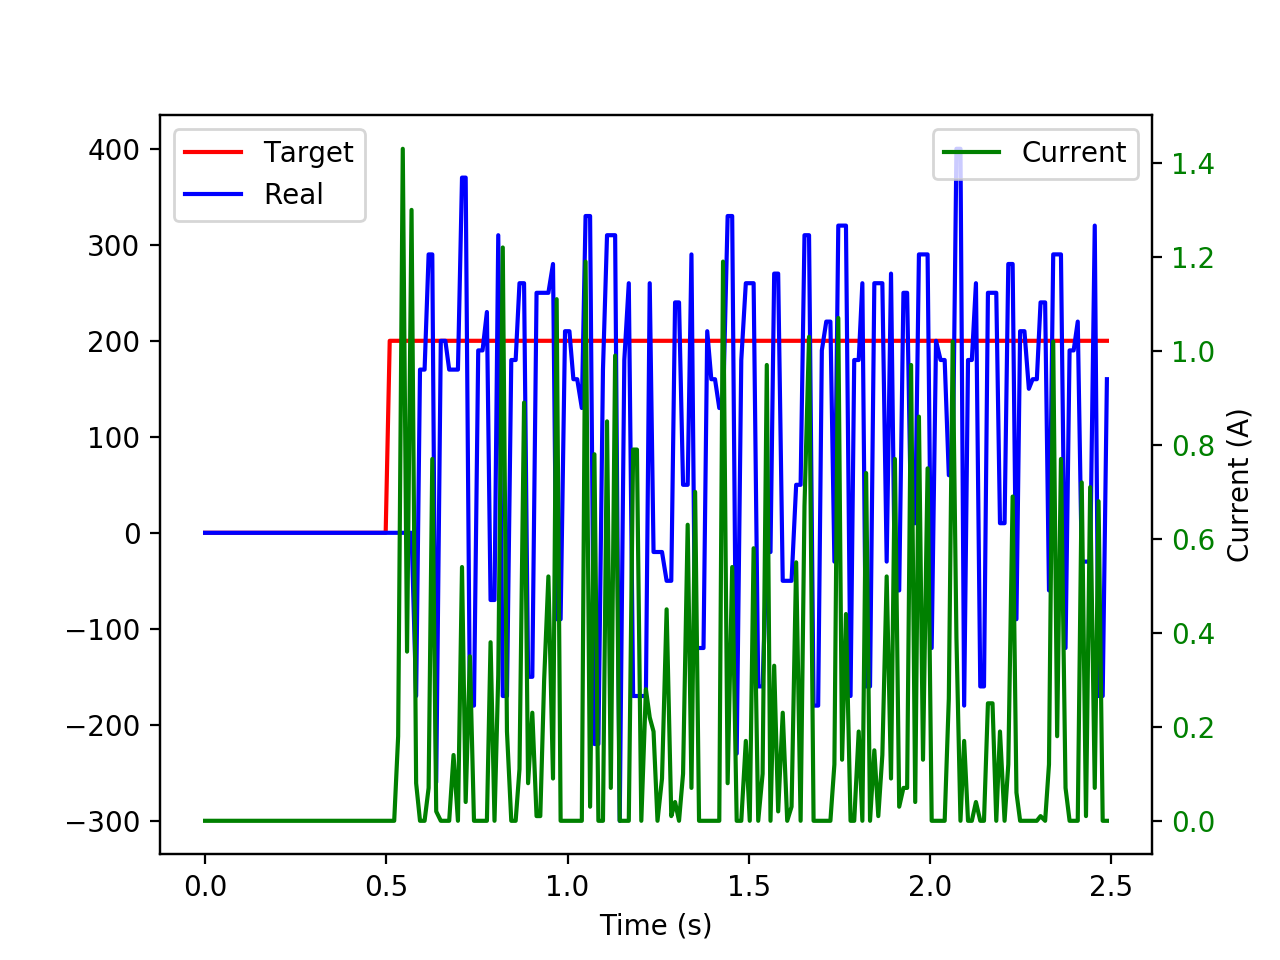

In [3]:
# Speed settings
module.speedPid = [1.0,0.0,0] # speed PID [P, I, D]
run_speed_test(200.0)

<IPython.core.display.Javascript object>


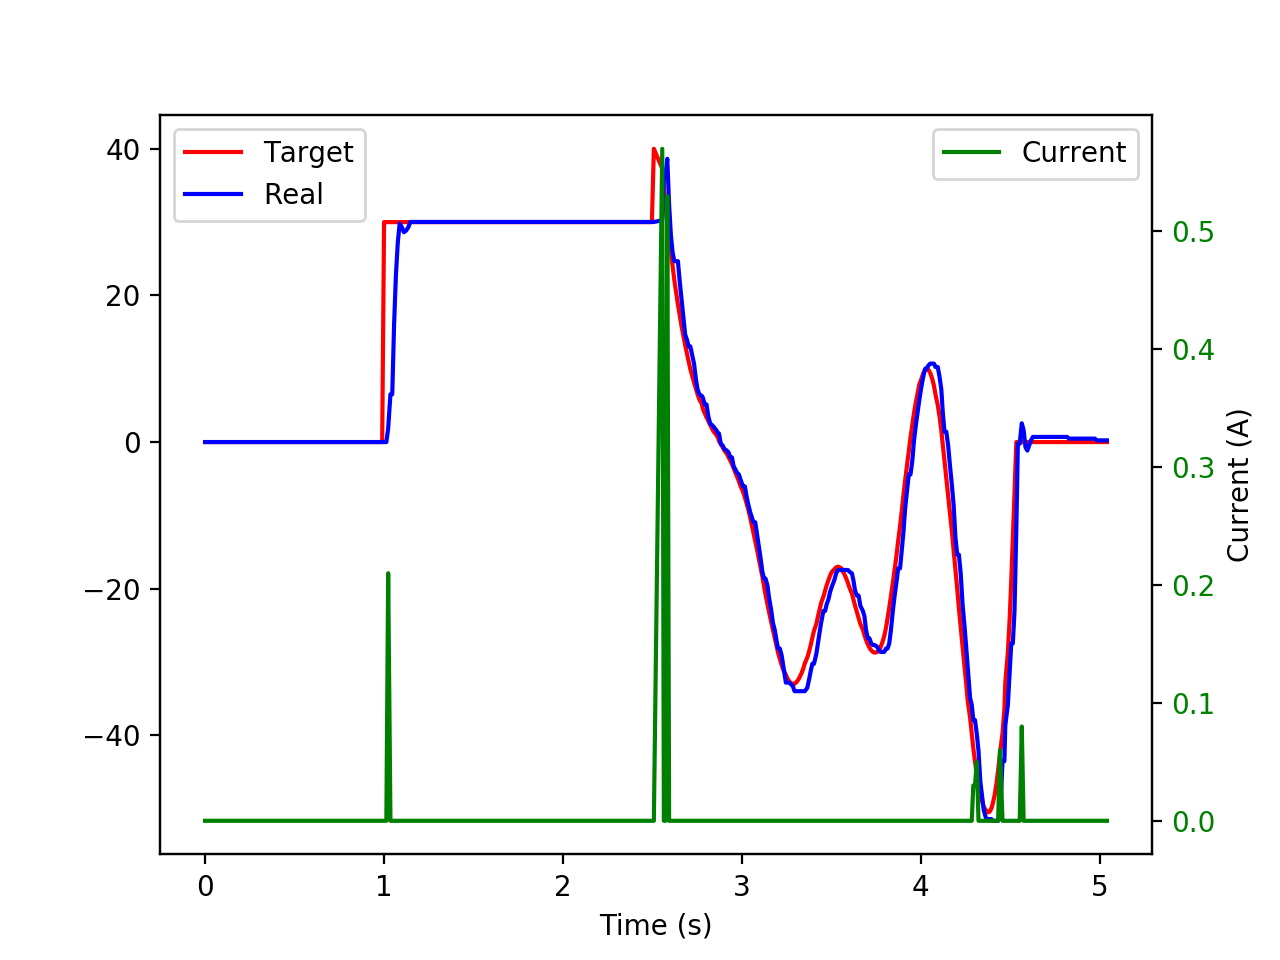

In [2]:
# position settings
module.limit_current = 6
module.positionPid = [10,0.04,90.0] # position PID [P, I, D]
run_pos_test(30.0)

In [4]:
import numpy as np
from scipy.interpolate import interp1d
moveduration = 2
keypoints = np.array([40, 4, -10, -33, -17, -27, 10, -40, 0])
x = np.linspace(0, 1, keypoints.shape[-1], endpoint=True)
traj = interp1d(x, keypoints, 'cubic')(np.linspace(0, 1, int(moveduration*100)))

In [5]:
traj

array([ 40.        ,  37.3167549 ,  34.76895063,  32.35240349,
        30.06292975,  27.8963457 ,  25.84846764,  23.91511183,
        22.09209458,  20.37523216,  18.76034087,  17.24323698,
        15.81973678,  14.48565657,  13.23681262,  12.06902121,
        10.97809865,   9.9598612 ,   9.01012517,   8.12470682,
         7.29942246,   6.53008836,   5.81252081,   5.1425361 ,
         4.51595051,   3.92858032,   3.37624183,   2.85475132,
         2.35992507,   1.88757938,   1.43353052,   0.99359478,
         0.56358845,   0.13932782,  -0.28337084,  -0.70869123,
        -1.14081707,  -1.58393207,  -2.04221995,  -2.51986442,
        -3.0210492 ,  -3.549958  ,  -4.11077454,  -4.70768252,
        -5.34486567,  -6.02650769,  -6.7567923 ,  -7.53990322,
        -8.38002416,  -9.28133884, -10.24799706, -11.28004664,
       -12.3695687 , -13.50772901, -14.68569337, -15.89462758,
       -17.12569741, -18.37006865, -19.61890711, -20.86337856,
       -22.0946488 , -23.30388361, -24.48224878, -25.62